In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='75'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs/profiles-v1/profiles-v1-pca'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
INPUT_PT_PATH = f"/workspace/datasets/profiles-v1/profiles-v1-pca/profiles-v1-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v1_pca_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_75_20250721_0107


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_75_20250721_0107/density_plot.png


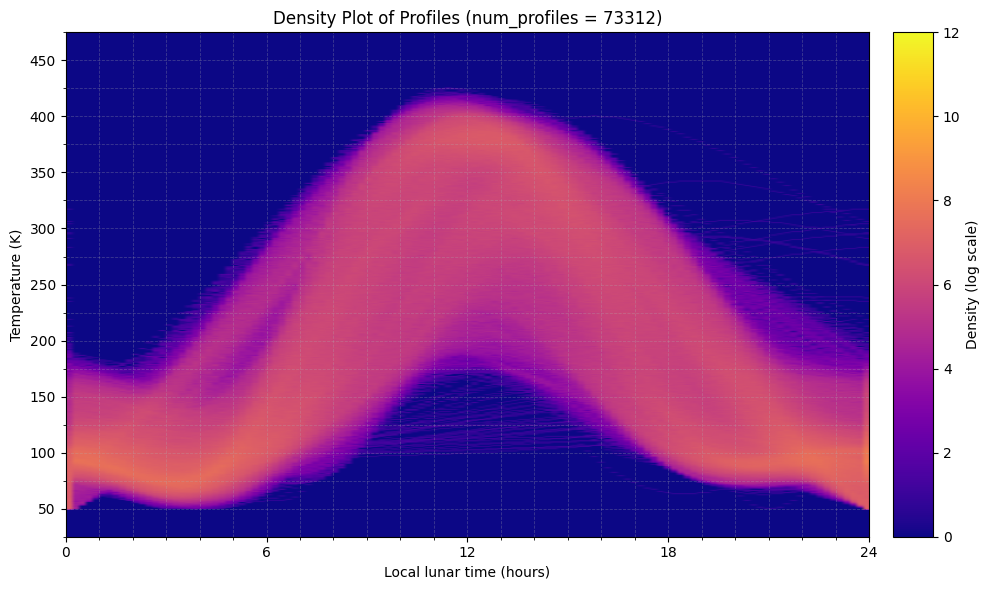

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 189.4731
STD: 96.6735
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 51318
Validation Data: 14662
Test Data: 7332


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 257/257 [00:09<00:00, 28.33it/s, best_loss=0.7145]


[Training] Epoch 1/100, L1 Loss: 0.7223, L2 Loss: 0.8044, KL Loss: 0.3292, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 74/74 [00:00<00:00, 105.30it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.6281, Val L2 Loss: 0.6473, Val KL Loss: 0.5249
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_75_20250721_0107'


[Training] Epoch 2/100: 100%|██████████| 257/257 [00:09<00:00, 27.72it/s, best_loss=0.7029]


[Training] Epoch 2/100, L1 Loss: 0.6520, L2 Loss: 0.6830, KL Loss: 0.5183, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 74/74 [00:00<00:00, 96.78it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.6162, Val L2 Loss: 0.6365, Val KL Loss: 0.5217
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_75_20250721_0107'


[Training] Epoch 3/100: 100%|██████████| 257/257 [00:09<00:00, 28.21it/s, best_loss=0.7076]


[Training] Epoch 3/100, L1 Loss: 0.6506, L2 Loss: 0.6817, KL Loss: 0.5202, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 74/74 [00:00<00:00, 97.76it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.6157, Val L2 Loss: 0.6356, Val KL Loss: 0.5233
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_75_20250721_0107'


[Training] Epoch 4/100: 100%|██████████| 257/257 [00:09<00:00, 28.10it/s, best_loss=0.6735]


[Training] Epoch 4/100, L1 Loss: 0.6504, L2 Loss: 0.6813, KL Loss: 0.5218, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 74/74 [00:00<00:00, 101.74it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.6157, Val L2 Loss: 0.6357, Val KL Loss: 0.5222


[Training] Epoch 5/100: 100%|██████████| 257/257 [00:08<00:00, 28.92it/s, best_loss=0.7075]


[Training] Epoch 5/100, L1 Loss: 0.6501, L2 Loss: 0.6807, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 74/74 [00:00<00:00, 94.56it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.6160, Val L2 Loss: 0.6363, Val KL Loss: 0.5215


[Training] Epoch 6/100: 100%|██████████| 257/257 [00:08<00:00, 28.70it/s, best_loss=0.7062]


[Training] Epoch 6/100, L1 Loss: 0.6502, L2 Loss: 0.6809, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 74/74 [00:00<00:00, 95.67it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.6164, Val L2 Loss: 0.6364, Val KL Loss: 0.5178


[Training] Epoch 7/100: 100%|██████████| 257/257 [00:08<00:00, 28.60it/s, best_loss=0.7104]


[Training] Epoch 7/100, L1 Loss: 0.6497, L2 Loss: 0.6803, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 74/74 [00:00<00:00, 101.19it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.6180, Val L2 Loss: 0.6376, Val KL Loss: 0.5170


[Training] Epoch 8/100: 100%|██████████| 257/257 [00:09<00:00, 28.16it/s, best_loss=0.7127]


[Training] Epoch 8/100, L1 Loss: 0.6499, L2 Loss: 0.6805, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 74/74 [00:00<00:00, 103.86it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.6169, Val L2 Loss: 0.6370, Val KL Loss: 0.5173


[Training] Epoch 9/100: 100%|██████████| 257/257 [00:09<00:00, 28.14it/s, best_loss=0.7076]


[Training] Epoch 9/100, L1 Loss: 0.6507, L2 Loss: 0.6818, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 74/74 [00:00<00:00, 96.50it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.6139, Val L2 Loss: 0.6341, Val KL Loss: 0.5267
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_75_20250721_0107'


[Training] Epoch 10/100: 100%|██████████| 257/257 [00:09<00:00, 28.28it/s, best_loss=0.6867]


[Training] Epoch 10/100, L1 Loss: 0.6503, L2 Loss: 0.6812, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 74/74 [00:00<00:00, 88.50it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.6163, Val L2 Loss: 0.6364, Val KL Loss: 0.5255


[Training] Epoch 11/100: 100%|██████████| 257/257 [00:09<00:00, 27.30it/s, best_loss=0.7080]


[Training] Epoch 11/100, L1 Loss: 0.6502, L2 Loss: 0.6806, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 74/74 [00:00<00:00, 98.53it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.6181, Val L2 Loss: 0.6379, Val KL Loss: 0.5162


[Training] Epoch 12/100: 100%|██████████| 257/257 [00:09<00:00, 28.02it/s, best_loss=0.6935]


[Training] Epoch 12/100, L1 Loss: 0.6503, L2 Loss: 0.6812, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 74/74 [00:00<00:00, 94.49it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.6164, Val L2 Loss: 0.6365, Val KL Loss: 0.5194


[Training] Epoch 13/100: 100%|██████████| 257/257 [00:09<00:00, 28.29it/s, best_loss=0.7156]


[Training] Epoch 13/100, L1 Loss: 0.6503, L2 Loss: 0.6812, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 74/74 [00:00<00:00, 97.64it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.6198, Val L2 Loss: 0.6392, Val KL Loss: 0.5150


[Training] Epoch 14/100: 100%|██████████| 257/257 [00:09<00:00, 28.31it/s, best_loss=0.7025]


[Training] Epoch 14/100, L1 Loss: 0.6501, L2 Loss: 0.6809, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 74/74 [00:00<00:00, 98.25it/s] 


[Validation] Epoch 14/100, Val L1 Loss: 0.6154, Val L2 Loss: 0.6354, Val KL Loss: 0.5257


[Training] Epoch 15/100: 100%|██████████| 257/257 [00:08<00:00, 29.11it/s, best_loss=0.6744]


[Training] Epoch 15/100, L1 Loss: 0.6498, L2 Loss: 0.6800, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 74/74 [00:00<00:00, 99.13it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.6154, Val L2 Loss: 0.6357, Val KL Loss: 0.5237


[Training] Epoch 16/100: 100%|██████████| 257/257 [00:09<00:00, 27.95it/s, best_loss=0.7174]


[Training] Epoch 16/100, L1 Loss: 0.6500, L2 Loss: 0.6808, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 74/74 [00:00<00:00, 97.47it/s] 


[Validation] Epoch 16/100, Val L1 Loss: 0.6169, Val L2 Loss: 0.6369, Val KL Loss: 0.5173


[Training] Epoch 17/100: 100%|██████████| 257/257 [00:09<00:00, 28.48it/s, best_loss=0.7117]


[Training] Epoch 17/100, L1 Loss: 0.6499, L2 Loss: 0.6807, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 74/74 [00:00<00:00, 97.22it/s] 


[Validation] Epoch 17/100, Val L1 Loss: 0.6126, Val L2 Loss: 0.6329, Val KL Loss: 0.5287
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_75_20250721_0107'


[Training] Epoch 18/100: 100%|██████████| 257/257 [00:08<00:00, 29.25it/s, best_loss=0.6857]


[Training] Epoch 18/100, L1 Loss: 0.6503, L2 Loss: 0.6810, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 74/74 [00:00<00:00, 95.91it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.6176, Val L2 Loss: 0.6373, Val KL Loss: 0.5187


[Training] Epoch 19/100: 100%|██████████| 257/257 [00:08<00:00, 29.47it/s, best_loss=0.6932]


[Training] Epoch 19/100, L1 Loss: 0.6504, L2 Loss: 0.6811, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 74/74 [00:00<00:00, 91.39it/s] 


[Validation] Epoch 19/100, Val L1 Loss: 0.6149, Val L2 Loss: 0.6350, Val KL Loss: 0.5294


[Training] Epoch 20/100: 100%|██████████| 257/257 [00:08<00:00, 28.79it/s, best_loss=0.6965]


[Training] Epoch 20/100, L1 Loss: 0.6497, L2 Loss: 0.6802, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 74/74 [00:00<00:00, 98.26it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.6186, Val L2 Loss: 0.6384, Val KL Loss: 0.5102


[Training] Epoch 21/100: 100%|██████████| 257/257 [00:09<00:00, 28.49it/s, best_loss=0.7120]


[Training] Epoch 21/100, L1 Loss: 0.6500, L2 Loss: 0.6807, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 74/74 [00:00<00:00, 98.77it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.6160, Val L2 Loss: 0.6359, Val KL Loss: 0.5219


[Training] Epoch 22/100: 100%|██████████| 257/257 [00:08<00:00, 29.03it/s, best_loss=0.6910]


[Training] Epoch 22/100, L1 Loss: 0.6501, L2 Loss: 0.6810, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 74/74 [00:00<00:00, 103.37it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.6169, Val L2 Loss: 0.6369, Val KL Loss: 0.5170


[Training] Epoch 23/100: 100%|██████████| 257/257 [00:08<00:00, 28.91it/s, best_loss=0.7111]


[Training] Epoch 23/100, L1 Loss: 0.6500, L2 Loss: 0.6807, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 74/74 [00:00<00:00, 89.60it/s] 


[Validation] Epoch 23/100, Val L1 Loss: 0.6164, Val L2 Loss: 0.6364, Val KL Loss: 0.5185


[Training] Epoch 24/100: 100%|██████████| 257/257 [00:08<00:00, 28.63it/s, best_loss=0.7019]


[Training] Epoch 24/100, L1 Loss: 0.6500, L2 Loss: 0.6808, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 74/74 [00:00<00:00, 99.70it/s] 


[Validation] Epoch 24/100, Val L1 Loss: 0.6174, Val L2 Loss: 0.6372, Val KL Loss: 0.5165


[Training] Epoch 25/100: 100%|██████████| 257/257 [00:08<00:00, 29.02it/s, best_loss=0.6858]


[Training] Epoch 25/100, L1 Loss: 0.6499, L2 Loss: 0.6807, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 74/74 [00:00<00:00, 98.50it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.6185, Val L2 Loss: 0.6382, Val KL Loss: 0.5109


[Training] Epoch 26/100: 100%|██████████| 257/257 [00:08<00:00, 28.74it/s, best_loss=0.7118]


[Training] Epoch 26/100, L1 Loss: 0.6502, L2 Loss: 0.6810, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 74/74 [00:00<00:00, 91.39it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.6146, Val L2 Loss: 0.6347, Val KL Loss: 0.5258


[Training] Epoch 27/100: 100%|██████████| 257/257 [00:08<00:00, 28.71it/s, best_loss=0.7026]


[Training] Epoch 27/100, L1 Loss: 0.6496, L2 Loss: 0.6801, KL Loss: 0.5221, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 74/74 [00:00<00:00, 86.78it/s] 


[Validation] Epoch 27/100, Val L1 Loss: 0.6188, Val L2 Loss: 0.6385, Val KL Loss: 0.5123


[Training] Epoch 28/100: 100%|██████████| 257/257 [00:08<00:00, 29.06it/s, best_loss=0.6812]


[Training] Epoch 28/100, L1 Loss: 0.6501, L2 Loss: 0.6807, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 74/74 [00:00<00:00, 96.95it/s] 


[Validation] Epoch 28/100, Val L1 Loss: 0.6168, Val L2 Loss: 0.6366, Val KL Loss: 0.5199


[Training] Epoch 29/100: 100%|██████████| 257/257 [00:08<00:00, 28.73it/s, best_loss=0.6953]


[Training] Epoch 29/100, L1 Loss: 0.6503, L2 Loss: 0.6811, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 74/74 [00:00<00:00, 95.20it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.6181, Val L2 Loss: 0.6379, Val KL Loss: 0.5145


[Training] Epoch 30/100: 100%|██████████| 257/257 [00:08<00:00, 29.14it/s, best_loss=0.7032]


[Training] Epoch 30/100, L1 Loss: 0.6499, L2 Loss: 0.6807, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 74/74 [00:00<00:00, 102.19it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.6149, Val L2 Loss: 0.6349, Val KL Loss: 0.5220


[Training] Epoch 31/100: 100%|██████████| 257/257 [00:09<00:00, 28.39it/s, best_loss=0.7003]


[Training] Epoch 31/100, L1 Loss: 0.6497, L2 Loss: 0.6803, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 74/74 [00:00<00:00, 86.75it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.6198, Val L2 Loss: 0.6393, Val KL Loss: 0.5111


[Training] Epoch 32/100: 100%|██████████| 257/257 [00:09<00:00, 28.41it/s, best_loss=0.7028]


[Training] Epoch 32/100, L1 Loss: 0.6498, L2 Loss: 0.6804, KL Loss: 0.5220, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 74/74 [00:00<00:00, 100.36it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.6181, Val L2 Loss: 0.6377, Val KL Loss: 0.5172


[Training] Epoch 33/100: 100%|██████████| 257/257 [00:09<00:00, 28.22it/s, best_loss=0.7096]


[Training] Epoch 33/100, L1 Loss: 0.6503, L2 Loss: 0.6810, KL Loss: 0.5220, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 74/74 [00:00<00:00, 103.01it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.6144, Val L2 Loss: 0.6346, Val KL Loss: 0.5226


[Training] Epoch 34/100: 100%|██████████| 257/257 [00:08<00:00, 28.72it/s, best_loss=0.7059]


[Training] Epoch 34/100, L1 Loss: 0.6502, L2 Loss: 0.6808, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 74/74 [00:00<00:00, 98.76it/s] 


[Validation] Epoch 34/100, Val L1 Loss: 0.6169, Val L2 Loss: 0.6367, Val KL Loss: 0.5181


[Training] Epoch 35/100: 100%|██████████| 257/257 [00:08<00:00, 28.69it/s, best_loss=0.7034]


[Training] Epoch 35/100, L1 Loss: 0.6499, L2 Loss: 0.6804, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 74/74 [00:00<00:00, 98.14it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.6151, Val L2 Loss: 0.6351, Val KL Loss: 0.5228


[Training] Epoch 36/100: 100%|██████████| 257/257 [00:09<00:00, 28.50it/s, best_loss=0.6975]


[Training] Epoch 36/100, L1 Loss: 0.6502, L2 Loss: 0.6810, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 74/74 [00:00<00:00, 102.45it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.6136, Val L2 Loss: 0.6339, Val KL Loss: 0.5280


[Training] Epoch 37/100: 100%|██████████| 257/257 [00:09<00:00, 28.10it/s, best_loss=0.6993]


[Training] Epoch 37/100, L1 Loss: 0.6501, L2 Loss: 0.6803, KL Loss: 0.5220, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 74/74 [00:00<00:00, 100.31it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.6163, Val L2 Loss: 0.6362, Val KL Loss: 0.5201


[Training] Epoch 38/100: 100%|██████████| 257/257 [00:08<00:00, 28.70it/s, best_loss=0.6902]


[Training] Epoch 38/100, L1 Loss: 0.6501, L2 Loss: 0.6808, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 74/74 [00:00<00:00, 100.37it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.6189, Val L2 Loss: 0.6388, Val KL Loss: 0.5136


[Training] Epoch 39/100: 100%|██████████| 257/257 [00:09<00:00, 27.61it/s, best_loss=0.7103]


[Training] Epoch 39/100, L1 Loss: 0.6496, L2 Loss: 0.6803, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 74/74 [00:00<00:00, 97.92it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.6163, Val L2 Loss: 0.6364, Val KL Loss: 0.5182


[Training] Epoch 40/100: 100%|██████████| 257/257 [00:08<00:00, 28.79it/s, best_loss=0.6926]


[Training] Epoch 40/100, L1 Loss: 0.6499, L2 Loss: 0.6807, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 74/74 [00:00<00:00, 103.04it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.6144, Val L2 Loss: 0.6347, Val KL Loss: 0.5242


[Training] Epoch 41/100: 100%|██████████| 257/257 [00:08<00:00, 28.89it/s, best_loss=0.7053]


[Training] Epoch 41/100, L1 Loss: 0.6499, L2 Loss: 0.6806, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 74/74 [00:00<00:00, 98.95it/s] 


[Validation] Epoch 41/100, Val L1 Loss: 0.6179, Val L2 Loss: 0.6377, Val KL Loss: 0.5205


[Training] Epoch 42/100: 100%|██████████| 257/257 [00:09<00:00, 28.43it/s, best_loss=0.7062]


[Training] Epoch 42/100, L1 Loss: 0.6497, L2 Loss: 0.6800, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 74/74 [00:00<00:00, 95.90it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.6146, Val L2 Loss: 0.6349, Val KL Loss: 0.5242


[Training] Epoch 43/100: 100%|██████████| 257/257 [00:09<00:00, 27.56it/s, best_loss=0.7041]


[Training] Epoch 43/100, L1 Loss: 0.6502, L2 Loss: 0.6809, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 74/74 [00:00<00:00, 95.66it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.6163, Val L2 Loss: 0.6363, Val KL Loss: 0.5213


[Training] Epoch 44/100: 100%|██████████| 257/257 [00:09<00:00, 28.10it/s, best_loss=0.6787]


[Training] Epoch 44/100, L1 Loss: 0.6504, L2 Loss: 0.6813, KL Loss: 0.5220, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 74/74 [00:00<00:00, 94.71it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.6144, Val L2 Loss: 0.6347, Val KL Loss: 0.5230


[Training] Epoch 45/100: 100%|██████████| 257/257 [00:09<00:00, 28.07it/s, best_loss=0.7009]


[Training] Epoch 45/100, L1 Loss: 0.6497, L2 Loss: 0.6804, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 74/74 [00:00<00:00, 97.20it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.6159, Val L2 Loss: 0.6358, Val KL Loss: 0.5255


[Training] Epoch 46/100: 100%|██████████| 257/257 [00:09<00:00, 27.39it/s, best_loss=0.6946]


[Training] Epoch 46/100, L1 Loss: 0.6502, L2 Loss: 0.6811, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 74/74 [00:00<00:00, 99.10it/s] 


[Validation] Epoch 46/100, Val L1 Loss: 0.6169, Val L2 Loss: 0.6368, Val KL Loss: 0.5166


[Training] Epoch 47/100: 100%|██████████| 257/257 [00:09<00:00, 27.35it/s, best_loss=0.6992]


[Training] Epoch 47/100, L1 Loss: 0.6503, L2 Loss: 0.6811, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 74/74 [00:00<00:00, 96.69it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.6159, Val L2 Loss: 0.6360, Val KL Loss: 0.5192


[Training] Epoch 48/100: 100%|██████████| 257/257 [00:09<00:00, 26.99it/s, best_loss=0.6907]


[Training] Epoch 48/100, L1 Loss: 0.6504, L2 Loss: 0.6812, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 74/74 [00:00<00:00, 93.07it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.6173, Val L2 Loss: 0.6372, Val KL Loss: 0.5277


[Training] Epoch 49/100: 100%|██████████| 257/257 [00:09<00:00, 27.98it/s, best_loss=0.7168]


[Training] Epoch 49/100, L1 Loss: 0.6502, L2 Loss: 0.6811, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 74/74 [00:00<00:00, 91.14it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.6131, Val L2 Loss: 0.6335, Val KL Loss: 0.5279


[Training] Epoch 50/100: 100%|██████████| 257/257 [00:09<00:00, 27.82it/s, best_loss=0.6988]


[Training] Epoch 50/100, L1 Loss: 0.6500, L2 Loss: 0.6807, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 74/74 [00:00<00:00, 94.82it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.6169, Val L2 Loss: 0.6368, Val KL Loss: 0.5168


[Training] Epoch 51/100: 100%|██████████| 257/257 [00:09<00:00, 27.48it/s, best_loss=0.7116]


[Training] Epoch 51/100, L1 Loss: 0.6499, L2 Loss: 0.6804, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 74/74 [00:00<00:00, 92.63it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.6143, Val L2 Loss: 0.6346, Val KL Loss: 0.5225


[Training] Epoch 52/100: 100%|██████████| 257/257 [00:09<00:00, 27.43it/s, best_loss=0.7127]


[Training] Epoch 52/100, L1 Loss: 0.6497, L2 Loss: 0.6803, KL Loss: 0.5220, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 74/74 [00:00<00:00, 91.44it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.6167, Val L2 Loss: 0.6366, Val KL Loss: 0.5189


[Training] Epoch 53/100: 100%|██████████| 257/257 [00:09<00:00, 27.52it/s, best_loss=0.7048]


[Training] Epoch 53/100, L1 Loss: 0.6507, L2 Loss: 0.6815, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 74/74 [00:00<00:00, 98.40it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.6147, Val L2 Loss: 0.6347, Val KL Loss: 0.5264


[Training] Epoch 54/100: 100%|██████████| 257/257 [00:09<00:00, 27.62it/s, best_loss=0.7079]


[Training] Epoch 54/100, L1 Loss: 0.6505, L2 Loss: 0.6815, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 74/74 [00:00<00:00, 98.74it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.6152, Val L2 Loss: 0.6352, Val KL Loss: 0.5217


[Training] Epoch 55/100: 100%|██████████| 257/257 [00:09<00:00, 27.72it/s, best_loss=0.7024]


[Training] Epoch 55/100, L1 Loss: 0.6501, L2 Loss: 0.6809, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 74/74 [00:00<00:00, 88.78it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.6153, Val L2 Loss: 0.6355, Val KL Loss: 0.5229


[Training] Epoch 56/100: 100%|██████████| 257/257 [00:09<00:00, 27.06it/s, best_loss=0.6883]


[Training] Epoch 56/100, L1 Loss: 0.6502, L2 Loss: 0.6811, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 74/74 [00:00<00:00, 94.71it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.6151, Val L2 Loss: 0.6353, Val KL Loss: 0.5268


[Training] Epoch 57/100: 100%|██████████| 257/257 [00:09<00:00, 27.44it/s, best_loss=0.6995]


[Training] Epoch 57/100, L1 Loss: 0.6497, L2 Loss: 0.6804, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 74/74 [00:00<00:00, 93.20it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.6172, Val L2 Loss: 0.6371, Val KL Loss: 0.5183


[Training] Epoch 58/100: 100%|██████████| 257/257 [00:09<00:00, 27.27it/s, best_loss=0.7122]


[Training] Epoch 58/100, L1 Loss: 0.6503, L2 Loss: 0.6812, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 74/74 [00:00<00:00, 95.81it/s] 


[Validation] Epoch 58/100, Val L1 Loss: 0.6154, Val L2 Loss: 0.6355, Val KL Loss: 0.5223


[Training] Epoch 59/100: 100%|██████████| 257/257 [00:09<00:00, 27.21it/s, best_loss=0.6996]


[Training] Epoch 59/100, L1 Loss: 0.6500, L2 Loss: 0.6805, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 74/74 [00:00<00:00, 95.90it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.6200, Val L2 Loss: 0.6395, Val KL Loss: 0.5139


[Training] Epoch 60/100: 100%|██████████| 257/257 [00:09<00:00, 28.08it/s, best_loss=0.7037]


[Training] Epoch 60/100, L1 Loss: 0.6500, L2 Loss: 0.6808, KL Loss: 0.5220, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 74/74 [00:00<00:00, 91.86it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.6163, Val L2 Loss: 0.6362, Val KL Loss: 0.5141


[Training] Epoch 61/100: 100%|██████████| 257/257 [00:09<00:00, 27.41it/s, best_loss=0.7031]


[Training] Epoch 61/100, L1 Loss: 0.6502, L2 Loss: 0.6806, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 74/74 [00:00<00:00, 90.01it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.6173, Val L2 Loss: 0.6371, Val KL Loss: 0.5173


[Training] Epoch 62/100: 100%|██████████| 257/257 [00:09<00:00, 27.82it/s, best_loss=0.6827]


[Training] Epoch 62/100, L1 Loss: 0.6501, L2 Loss: 0.6811, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 74/74 [00:00<00:00, 96.04it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.6169, Val L2 Loss: 0.6368, Val KL Loss: 0.5191


[Training] Epoch 63/100: 100%|██████████| 257/257 [00:09<00:00, 27.33it/s, best_loss=0.7059]


[Training] Epoch 63/100, L1 Loss: 0.6501, L2 Loss: 0.6807, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 74/74 [00:00<00:00, 93.86it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.6189, Val L2 Loss: 0.6384, Val KL Loss: 0.5172


[Training] Epoch 64/100: 100%|██████████| 257/257 [00:09<00:00, 27.10it/s, best_loss=0.7016]


[Training] Epoch 64/100, L1 Loss: 0.6494, L2 Loss: 0.6799, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 74/74 [00:00<00:00, 94.65it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.6153, Val L2 Loss: 0.6353, Val KL Loss: 0.5218


[Training] Epoch 65/100: 100%|██████████| 257/257 [00:09<00:00, 27.27it/s, best_loss=0.6953]


[Training] Epoch 65/100, L1 Loss: 0.6500, L2 Loss: 0.6805, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 74/74 [00:00<00:00, 91.05it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.6168, Val L2 Loss: 0.6368, Val KL Loss: 0.5184


[Training] Epoch 66/100: 100%|██████████| 257/257 [00:09<00:00, 27.81it/s, best_loss=0.6990]


[Training] Epoch 66/100, L1 Loss: 0.6499, L2 Loss: 0.6806, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 74/74 [00:00<00:00, 91.52it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.6134, Val L2 Loss: 0.6337, Val KL Loss: 0.5262


[Training] Epoch 67/100: 100%|██████████| 257/257 [00:09<00:00, 27.40it/s, best_loss=0.7038]


[Training] Epoch 67/100, L1 Loss: 0.6496, L2 Loss: 0.6802, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 74/74 [00:00<00:00, 88.82it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.6129, Val L2 Loss: 0.6333, Val KL Loss: 0.5300


[Training] Epoch 68/100: 100%|██████████| 257/257 [00:09<00:00, 27.55it/s, best_loss=0.7164]


[Training] Epoch 68/100, L1 Loss: 0.6503, L2 Loss: 0.6809, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 74/74 [00:00<00:00, 95.65it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.6156, Val L2 Loss: 0.6357, Val KL Loss: 0.5216


[Training] Epoch 69/100: 100%|██████████| 257/257 [00:09<00:00, 27.99it/s, best_loss=0.6915]


[Training] Epoch 69/100, L1 Loss: 0.6492, L2 Loss: 0.6795, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 74/74 [00:00<00:00, 98.03it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.6172, Val L2 Loss: 0.6371, Val KL Loss: 0.5157


[Training] Epoch 70/100: 100%|██████████| 257/257 [00:09<00:00, 27.60it/s, best_loss=0.7098]


[Training] Epoch 70/100, L1 Loss: 0.6496, L2 Loss: 0.6802, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 74/74 [00:00<00:00, 88.34it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.6153, Val L2 Loss: 0.6353, Val KL Loss: 0.5219


[Training] Epoch 71/100: 100%|██████████| 257/257 [00:09<00:00, 27.58it/s, best_loss=0.6958]


[Training] Epoch 71/100, L1 Loss: 0.6499, L2 Loss: 0.6806, KL Loss: 0.5220, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 74/74 [00:00<00:00, 97.15it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.6179, Val L2 Loss: 0.6378, Val KL Loss: 0.5119


[Training] Epoch 72/100: 100%|██████████| 257/257 [00:09<00:00, 28.02it/s, best_loss=0.6867]


[Training] Epoch 72/100, L1 Loss: 0.6497, L2 Loss: 0.6802, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 74/74 [00:00<00:00, 99.42it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.6146, Val L2 Loss: 0.6349, Val KL Loss: 0.5249


[Training] Epoch 73/100: 100%|██████████| 257/257 [00:09<00:00, 27.70it/s, best_loss=0.6961]


[Training] Epoch 73/100, L1 Loss: 0.6498, L2 Loss: 0.6803, KL Loss: 0.5220, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 74/74 [00:00<00:00, 99.14it/s] 


[Validation] Epoch 73/100, Val L1 Loss: 0.6149, Val L2 Loss: 0.6352, Val KL Loss: 0.5192


[Training] Epoch 74/100: 100%|██████████| 257/257 [00:09<00:00, 28.00it/s, best_loss=0.6991]


[Training] Epoch 74/100, L1 Loss: 0.6503, L2 Loss: 0.6812, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 74/74 [00:00<00:00, 100.48it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.6150, Val L2 Loss: 0.6353, Val KL Loss: 0.5250


[Training] Epoch 75/100: 100%|██████████| 257/257 [00:09<00:00, 28.01it/s, best_loss=0.6856]


[Training] Epoch 75/100, L1 Loss: 0.6501, L2 Loss: 0.6810, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 74/74 [00:00<00:00, 92.44it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.6153, Val L2 Loss: 0.6354, Val KL Loss: 0.5214


[Training] Epoch 76/100: 100%|██████████| 257/257 [00:09<00:00, 27.95it/s, best_loss=0.7036]


[Training] Epoch 76/100, L1 Loss: 0.6499, L2 Loss: 0.6805, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 74/74 [00:00<00:00, 97.95it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.6160, Val L2 Loss: 0.6361, Val KL Loss: 0.5197


[Training] Epoch 77/100: 100%|██████████| 257/257 [00:09<00:00, 28.32it/s, best_loss=0.7103]


[Training] Epoch 77/100, L1 Loss: 0.6501, L2 Loss: 0.6806, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 74/74 [00:00<00:00, 94.19it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.6182, Val L2 Loss: 0.6380, Val KL Loss: 0.5159


[Training] Epoch 78/100: 100%|██████████| 257/257 [00:09<00:00, 28.32it/s, best_loss=0.7081]


[Training] Epoch 78/100, L1 Loss: 0.6497, L2 Loss: 0.6801, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 74/74 [00:00<00:00, 99.36it/s] 


[Validation] Epoch 78/100, Val L1 Loss: 0.6169, Val L2 Loss: 0.6367, Val KL Loss: 0.5206


[Training] Epoch 79/100: 100%|██████████| 257/257 [00:09<00:00, 27.60it/s, best_loss=0.6764]


[Training] Epoch 79/100, L1 Loss: 0.6499, L2 Loss: 0.6805, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 74/74 [00:00<00:00, 97.35it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.6157, Val L2 Loss: 0.6359, Val KL Loss: 0.5249


[Training] Epoch 80/100: 100%|██████████| 257/257 [00:09<00:00, 28.39it/s, best_loss=0.7121]


[Training] Epoch 80/100, L1 Loss: 0.6500, L2 Loss: 0.6806, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 74/74 [00:00<00:00, 98.30it/s] 


[Validation] Epoch 80/100, Val L1 Loss: 0.6162, Val L2 Loss: 0.6361, Val KL Loss: 0.5158


[Training] Epoch 81/100: 100%|██████████| 257/257 [00:09<00:00, 28.07it/s, best_loss=0.6959]


[Training] Epoch 81/100, L1 Loss: 0.6499, L2 Loss: 0.6806, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 74/74 [00:00<00:00, 93.11it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.6173, Val L2 Loss: 0.6370, Val KL Loss: 0.5223


[Training] Epoch 82/100: 100%|██████████| 257/257 [00:09<00:00, 28.51it/s, best_loss=0.6915]


[Training] Epoch 82/100, L1 Loss: 0.6502, L2 Loss: 0.6813, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 74/74 [00:00<00:00, 99.71it/s] 


[Validation] Epoch 82/100, Val L1 Loss: 0.6154, Val L2 Loss: 0.6356, Val KL Loss: 0.5241


[Training] Epoch 83/100: 100%|██████████| 257/257 [00:09<00:00, 27.39it/s, best_loss=0.7150]


[Training] Epoch 83/100, L1 Loss: 0.6497, L2 Loss: 0.6805, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 74/74 [00:00<00:00, 93.99it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.6166, Val L2 Loss: 0.6366, Val KL Loss: 0.5231


[Training] Epoch 84/100: 100%|██████████| 257/257 [00:09<00:00, 28.31it/s, best_loss=0.7115]


[Training] Epoch 84/100, L1 Loss: 0.6505, L2 Loss: 0.6813, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 74/74 [00:00<00:00, 90.06it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.6200, Val L2 Loss: 0.6395, Val KL Loss: 0.5102


[Training] Epoch 85/100: 100%|██████████| 257/257 [00:09<00:00, 27.77it/s, best_loss=0.7096]


[Training] Epoch 85/100, L1 Loss: 0.6503, L2 Loss: 0.6812, KL Loss: 0.5218, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 74/74 [00:00<00:00, 90.07it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.6163, Val L2 Loss: 0.6364, Val KL Loss: 0.5201


[Training] Epoch 86/100: 100%|██████████| 257/257 [00:09<00:00, 27.65it/s, best_loss=0.7165]


[Training] Epoch 86/100, L1 Loss: 0.6499, L2 Loss: 0.6805, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 74/74 [00:00<00:00, 98.77it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.6144, Val L2 Loss: 0.6347, Val KL Loss: 0.5229


[Training] Epoch 87/100: 100%|██████████| 257/257 [00:09<00:00, 27.32it/s, best_loss=0.6866]


[Training] Epoch 87/100, L1 Loss: 0.6497, L2 Loss: 0.6802, KL Loss: 0.5220, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 74/74 [00:00<00:00, 96.61it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.6151, Val L2 Loss: 0.6352, Val KL Loss: 0.5222


[Training] Epoch 88/100: 100%|██████████| 257/257 [00:09<00:00, 27.90it/s, best_loss=0.6883]


[Training] Epoch 88/100, L1 Loss: 0.6497, L2 Loss: 0.6801, KL Loss: 0.5220, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 74/74 [00:00<00:00, 95.79it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.6191, Val L2 Loss: 0.6387, Val KL Loss: 0.5094


[Training] Epoch 89/100: 100%|██████████| 257/257 [00:09<00:00, 27.53it/s, best_loss=0.7008]


[Training] Epoch 89/100, L1 Loss: 0.6498, L2 Loss: 0.6805, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 74/74 [00:00<00:00, 100.98it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.6141, Val L2 Loss: 0.6345, Val KL Loss: 0.5227


[Training] Epoch 90/100: 100%|██████████| 257/257 [00:09<00:00, 27.48it/s, best_loss=0.7161]


[Training] Epoch 90/100, L1 Loss: 0.6502, L2 Loss: 0.6808, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 74/74 [00:00<00:00, 95.07it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.6195, Val L2 Loss: 0.6393, Val KL Loss: 0.5091


[Training] Epoch 91/100: 100%|██████████| 257/257 [00:09<00:00, 27.21it/s, best_loss=0.7139]


[Training] Epoch 91/100, L1 Loss: 0.6504, L2 Loss: 0.6813, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 74/74 [00:00<00:00, 90.61it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.6154, Val L2 Loss: 0.6355, Val KL Loss: 0.5220


[Training] Epoch 92/100: 100%|██████████| 257/257 [00:09<00:00, 28.37it/s, best_loss=0.6959]


[Training] Epoch 92/100, L1 Loss: 0.6498, L2 Loss: 0.6806, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 74/74 [00:00<00:00, 100.94it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.6168, Val L2 Loss: 0.6367, Val KL Loss: 0.5212


[Training] Epoch 93/100: 100%|██████████| 257/257 [00:09<00:00, 28.43it/s, best_loss=0.7187]


[Training] Epoch 93/100, L1 Loss: 0.6503, L2 Loss: 0.6811, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 74/74 [00:00<00:00, 89.41it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.6141, Val L2 Loss: 0.6345, Val KL Loss: 0.5245


[Training] Epoch 94/100: 100%|██████████| 257/257 [00:09<00:00, 28.43it/s, best_loss=0.7077]


[Training] Epoch 94/100, L1 Loss: 0.6496, L2 Loss: 0.6797, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 74/74 [00:00<00:00, 94.11it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.6169, Val L2 Loss: 0.6369, Val KL Loss: 0.5201


[Training] Epoch 95/100: 100%|██████████| 257/257 [00:09<00:00, 27.53it/s, best_loss=0.7014]


[Training] Epoch 95/100, L1 Loss: 0.6500, L2 Loss: 0.6806, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 74/74 [00:00<00:00, 97.94it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.6132, Val L2 Loss: 0.6338, Val KL Loss: 0.5298


[Training] Epoch 96/100: 100%|██████████| 257/257 [00:09<00:00, 28.40it/s, best_loss=0.6961]


[Training] Epoch 96/100, L1 Loss: 0.6500, L2 Loss: 0.6807, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 74/74 [00:00<00:00, 94.56it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.6161, Val L2 Loss: 0.6361, Val KL Loss: 0.5201


[Training] Epoch 97/100: 100%|██████████| 257/257 [00:09<00:00, 27.88it/s, best_loss=0.7037]


[Training] Epoch 97/100, L1 Loss: 0.6499, L2 Loss: 0.6805, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 74/74 [00:00<00:00, 98.21it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.6157, Val L2 Loss: 0.6359, Val KL Loss: 0.5236


[Training] Epoch 98/100: 100%|██████████| 257/257 [00:09<00:00, 27.73it/s, best_loss=0.7051]


[Training] Epoch 98/100, L1 Loss: 0.6499, L2 Loss: 0.6810, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 74/74 [00:00<00:00, 97.78it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.6178, Val L2 Loss: 0.6376, Val KL Loss: 0.5153


[Training] Epoch 99/100: 100%|██████████| 257/257 [00:09<00:00, 27.76it/s, best_loss=0.7131]


[Training] Epoch 99/100, L1 Loss: 0.6498, L2 Loss: 0.6804, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 74/74 [00:00<00:00, 95.82it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.6131, Val L2 Loss: 0.6334, Val KL Loss: 0.5347


[Training] Epoch 100/100: 100%|██████████| 257/257 [00:09<00:00, 28.32it/s, best_loss=0.7043]


[Training] Epoch 100/100, L1 Loss: 0.6498, L2 Loss: 0.6803, KL Loss: 0.5219, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 74/74 [00:00<00:00, 99.49it/s] 


[Validation] Epoch 100/100, Val L1 Loss: 0.6153, Val L2 Loss: 0.6354, Val KL Loss: 0.5268


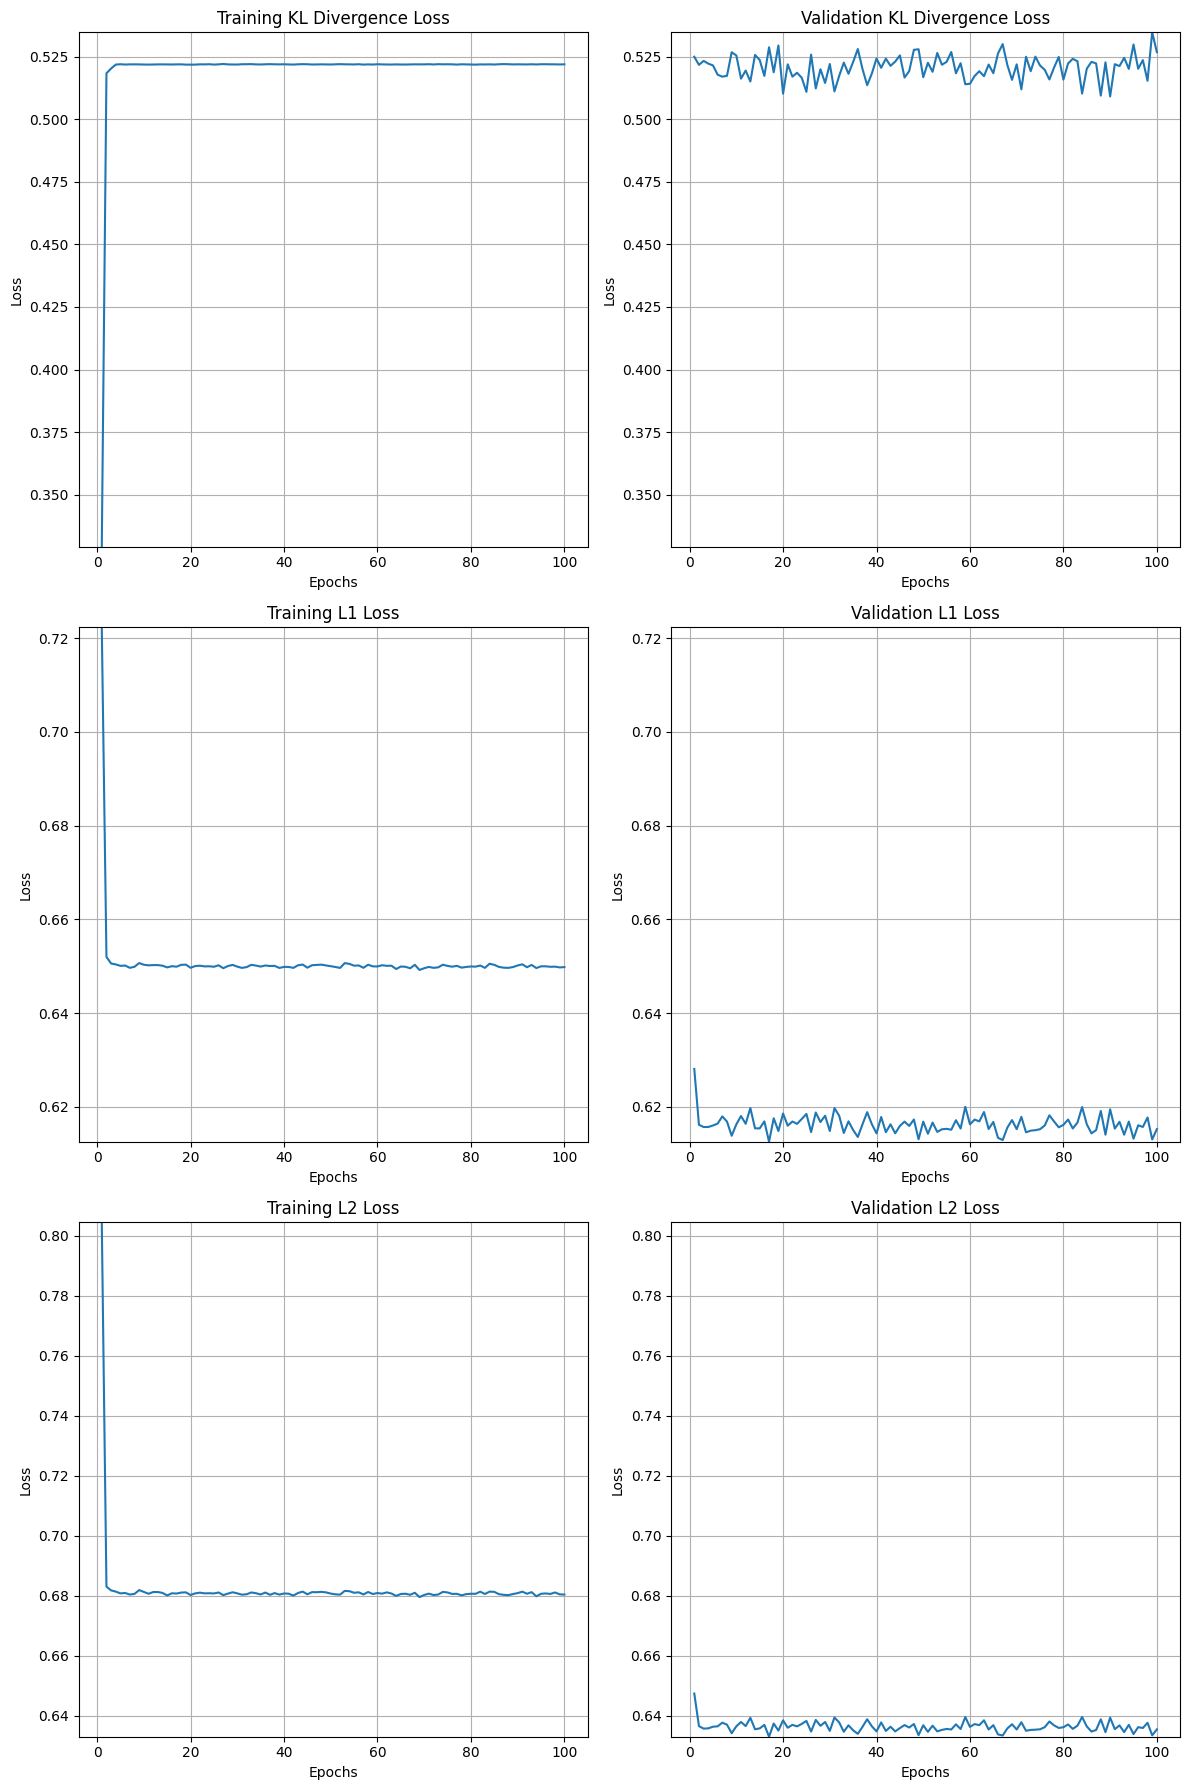

Best Validation Loss in Kelvins:
59.2206 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


z0: -0.0077
z1: -0.0411
z2: 0.0321
z3: 0.0151


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 737.17it/s]


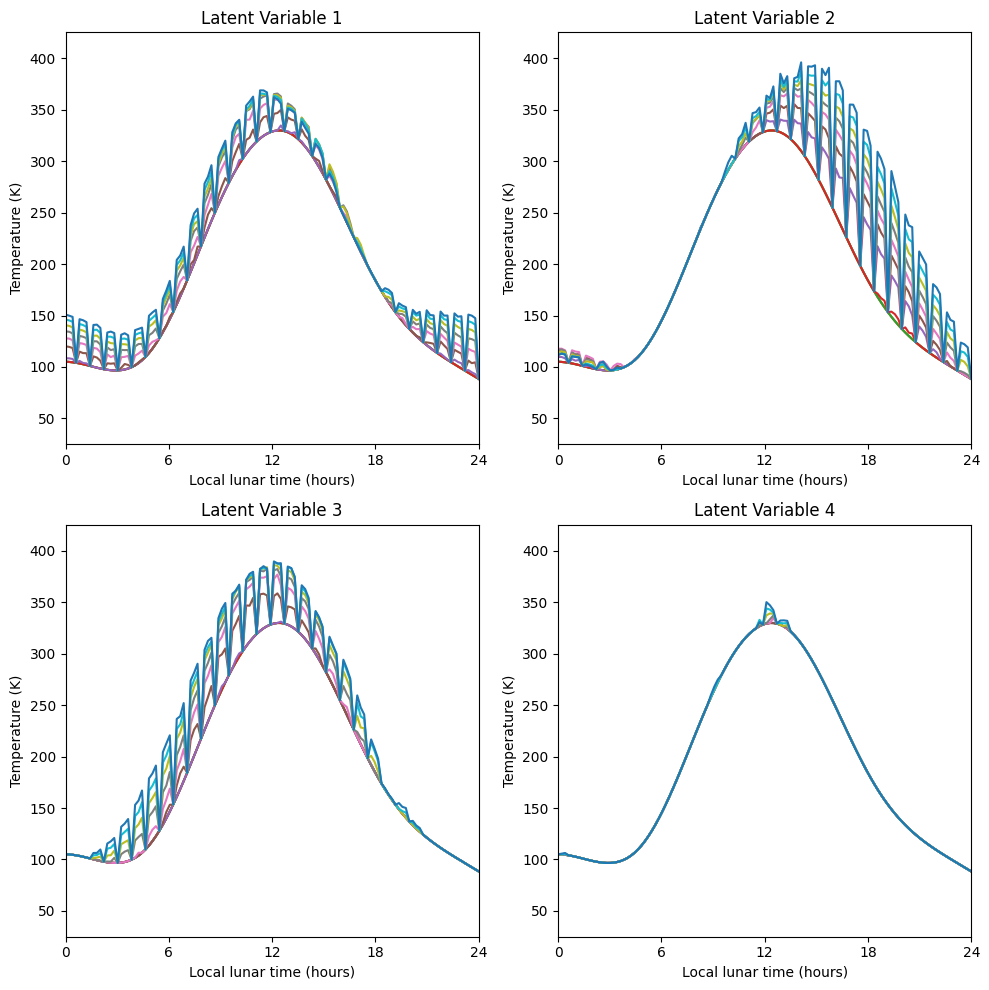

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)